## 2.1 k-Nearest Neighbors

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from collections import Counter

2.1.1 Generating the data

In [4]:
# Generate the random samples
num_points = 100
X = np.random.rand(num_points, 2) # 100 points in [0,1]^2
y = np.random.randint(0, 2, num_points) # Labels sampled uniformly from {0,1}

In [5]:
# Define the k-NN hypothesis function
def knn_hypothesis(query_point, X, y, k=3):
  # Calculate Euclidean distances from the query point to all points in X
  distances = distance.cdist([query_point], X, metric = "euclidean").flatten()

  # Get index of k nearest neighbors
  nearest_indices = np.argsort(distances)[:k]

  # Get labels of the k nearest neighbours
  nearest_labels = y[nearest_indices]

  # Determine the majority label
  counts = np.bincount(nearest_labels, minlength=2)
  if counts[0] >  counts[1]:
    return 0 # Majority is label 0
  elif counts[1] > counts[0]:
    return 1 # Majority is label 1
  else:
    return None

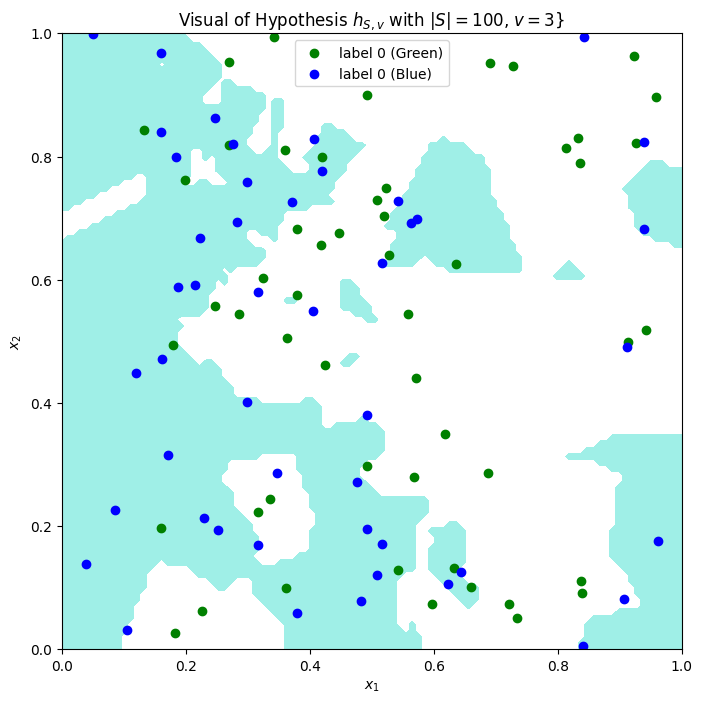

In [6]:
# Visualise the hypothesis

# Create a grid of 100 test points in [0,1]^2
grid_size = 100
x_grid = np.linspace(0, 1, grid_size)
y_grid = np.linspace(0, 1, grid_size)
xx, yy = np.meshgrid(x_grid, y_grid)
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Compute the labels for each grid point
grid_labels = []
for point in grid_points:
  label = knn_hypothesis(point, X, y, k=3)
  grid_labels.append(label)

grid_labels = np.array(grid_labels).reshape(grid_size, grid_size)

# Plot the result
plt.figure(figsize=(8,8))
plt.contourf(xx,yy, grid_labels, levels=[-0.5, 0.5, 1.5], colors=['white', 'turquoise'], alpha = 0.5)
plt.scatter(X[y == 0,0], X[y == 0, 1], color='green', label='label 0 (Green)')
plt.scatter(X[y == 1,0], X[y == 1, 1], color='blue', label='label 0 (Blue)')
plt.title("Visual of Hypothesis $h_{S,v}$ with $|S|=100$, $v=3$}")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend()
plt.show()

2.1.2 Estimated generalization error of k-NN as a function of k

In [7]:
# Static Hypothesis Generator
def generate_static_hypothesis():
    X_h = np.random.rand(100, 2) # 100 random 2D points
    y_h = np.random.randint(0, 2, size=100) # corresponding binary labels
    return X_h, y_h

In [8]:
# Compute the Euclidean distance between two points X1 and X2
def compute_pairwise_distances(X1, X2):
    norm_squared_X1 = np.sum(X1**2, axis=1).reshape(-1, 1)  
    norm_squared_X2 = np.sum(X2**2, axis=1).reshape(1, -1)  
    squared_distances = norm_squared_X1 + norm_squared_X2 - 2 * np.dot(X1, X2.T)
    return np.sqrt(np.maximum(squared_distances, 0))  # Avoid negative values due to numerical errors

In [9]:
# k-NN Predictor
def knn_predict(X_train, y_train, X_test, k):
    distances = compute_pairwise_distances(X_train, X_test) #compute all distances
    k_indices = np.argsort(distances, axis=0)[:k] # get indices of k nearest neighbors
    k_labels = y_train[k_indices] # get labels of k nearest neighbors
    predictions = [Counter(k).most_common(1)[0][0] for k in k_labels.T] # get majority label
    return np.array(predictions)

In [10]:
# Synthetic training/testing data along with labels 
def generate_data(n, X_h, y_h, k):
    X = np.random.rand(n, 2)
    coins = np.random.choice([0, 1], size=n, p=[0.2, 0.8])
    knn_labels = knn_predict(X_h, y_h, X, k)  # Generate lables using k-NN (k=3)
    y = np.where(coins == 0, np.random.randint(0, 2, size=n), knn_labels) # Assign labels
    return X, y

In [11]:
def protocol_a(k_values, num_runs, train_size=4000, test_size=1000):  # Static Hypothesis
    errors = []  # List to store mean errors for each k

    for k in k_values:  # Outer loop over k
        error = 0 
        
        for run in range(num_runs):  # Inner loop over runs
            X, y = generate_static_hypothesis()
            
            # Generate training and test data
            X_train, y_train = generate_data(train_size, X, y, k=3)
            X_test, y_test = generate_data(test_size, X, y, k=3)
            
            # Predict and compute error
            predictions = knn_predict(X_train, y_train, X_test, k)
            error += np.mean(predictions != y_test) 
        
        # Compute mean error for this k after all runs
        mean_error = error / num_runs
        errors.append(mean_error)
        print(f"k={k}: Mean Error = {mean_error:.4f}")

    return errors

In [12]:
# Visualize the results
k_values = range(1, 50)
num_runs = 100
mean_errors = protocol_a(k_values, num_runs)

plt.figure(figsize=(10, 6))
plt.plot(k_values, mean_errors, marker='o', label="Generalization Error")
plt.title("Generalization Error vs. k (Optimized Protocol A)")
plt.xlabel("k (Number of Neighbors)")
plt.ylabel("Mean Generalization Error")
plt.grid(True)
plt.legend()
plt.show()

k=1: Mean Error = 0.2052
k=2: Mean Error = 0.2033
k=3: Mean Error = 0.1587
k=4: Mean Error = 0.1565
k=5: Mean Error = 0.1462
k=6: Mean Error = 0.1456
k=7: Mean Error = 0.1441


2.1.3 Determine the optimal k as a function of the number of training points (m)

In [ ]:
# Protocol B 
def protocol_b(m_values, k_values, num_runs=100, test_size=1000, prob_heads=0.8):
    mean_optimal_ks = [] 

    for m in m_values:  # Outer loop over training set sizes
        print(f"Processing m={m}...")
        tmp_optimal_k = []  # Temporary list to store optimal k for this m

        for run in range(num_runs):  # Inner loop over runs
            if run % 10 == 0:
                print(f"  Run {run + 1}/{num_runs} for m={m}...")

            # Generate training and test data
            X_h, y_h = generate_static_hypothesis()
            X_train, y_train = generate_data(m, X_h, y_h, k=3)
            X_test, y_test = generate_data(test_size, X_h, y_h, k=3)

            # Find the optimal k by evaluating all k values
            optimal_k = None
            min_error = float('inf')  # Initialize minimum error
            for k in k_values:
                predictions = knn_predict(X_train, y_train, X_test, k)
                error = np.mean(predictions != y_test)  # Compute error
                if error < min_error:  # Update optimal k and minimum error
                    min_error = error
                    optimal_k = k

            tmp_optimal_k.append(optimal_k)  # Store the optimal k for this run

        # Compute mean optimal k for this m
        mean_k = np.mean(tmp_optimal_k)
        mean_optimal_ks.append(mean_k)
        print(f"m={m}: Mean Optimal k = {mean_k:.4f}")

    return mean_optimal_ks

In [ ]:
# Visualize the results
m_values = [100, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]  # Training set sizes
k_values = range(1, 50)
num_runs = 100

mean_optimal_ks = protocol_b(m_values, k_values, num_runs)

plt.figure(figsize=(10, 6))
plt.plot(m_values, mean_optimal_ks, marker='o', label="Mean Optimal k")
plt.title("Optimal k vs Training Set Size m (Protocol B)")
plt.xlabel("Training Set Size (m)")
plt.ylabel("Mean Optimal k")
plt.grid(True)
plt.legend()
plt.show()